Objective: To categorize unseen pictures (test data) into cats and dogs by training a convolutional network on a dataset including images of cats and dogs. The model will learn the characteristics of these images.  

1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text. Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?

### Downloading the data

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hanishbhogadi","key":"93a196a669a3693f8e2103b6868721d4"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
!kaggle competitions download -c dogs-vs-cats

 99% 802M/812M [00:06<00:00, 176MB/s]
100% 812M/812M [00:06<00:00, 122MB/s]


In [6]:
!unzip -qq dogs-vs-cats.zip

In [7]:
!unzip -qq train.zip

**Copying images to training, validation, and test directories**

In [8]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

**Using `image_dataset_from_directory` to read images**

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [10]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [11]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [12]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [13]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [14]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5) (x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Configuring the model for training**

In [17]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Data preprocessing

**Displaying the shapes of the data and labels yielded by the `Dataset`**

**Fitting the model using a `Dataset`**

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 15s 83ms/step - loss: 0.6941 - accuracy: 0.5055 - val_loss: 0.6908 - val_accuracy: 0.5830
Epoch 2/30
63/63 [==============================] - 5s 72ms/step - loss: 0.6849 - accuracy: 0.5725 - val_loss: 0.6597 - val_accuracy: 0.6110
Epoch 3/30
63/63 [==============================] - 5s 70ms/step - loss: 0.6629 - accuracy: 0.5935 - val_loss: 0.6956 - val_accuracy: 0.5120
Epoch 4/30
63/63 [==============================] - 5s 70ms/step - loss: 0.6608 - accuracy: 0.6105 - val_loss: 0.6331 - val_accuracy: 0.6460
Epoch 5/30
63/63 [==============================] - 5s 72ms/step - loss: 0.6226 - accuracy: 0.6575 - val_loss: 0.5908 - val_accuracy: 0.6890
Epoch 6/30
63/63 [==============================] - 5s 70ms/step - loss: 0.5868 - accuracy: 0.7095 - val_loss: 0.6014 - val_accuracy: 0.6730
Epoch 7/30
63/63 [==============================] - 5s 71ms/step - loss: 0.5885 - accuracy: 0.6915 - val_loss: 0.5793 - val_accuracy: 0.6980
Epoch 8/30
6

**Displaying curves of loss and accuracy during training**

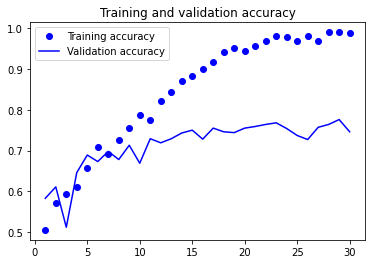

<Figure size 432x288 with 0 Axes>

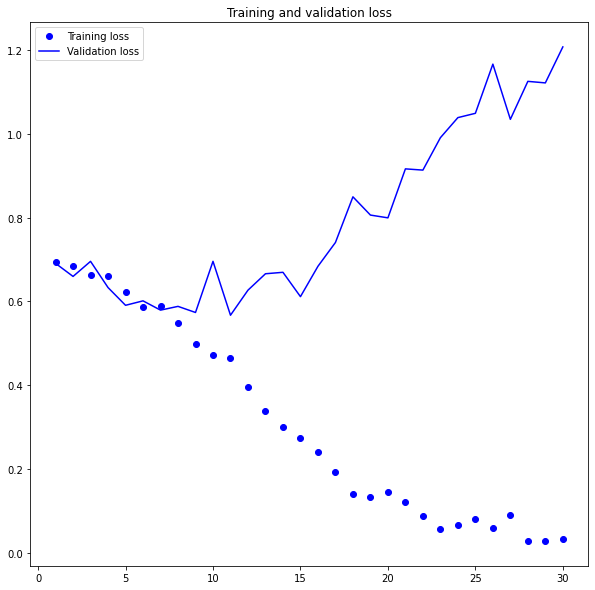

In [19]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [20]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 36ms/step - loss: 0.6322 - accuracy: 0.7020
Test accuracy: 0.702


The above model clearly indicates that the model is overfit with a train accuracy of 97.85%. 
We have considered Epoch 23 to evaluate the model.
Test Accuracy - 70.2 which means model is unable to generalize well.

Moving further we will try to reduce overfit and able to generalize well by using different techniques.

Q2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [21]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [22]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

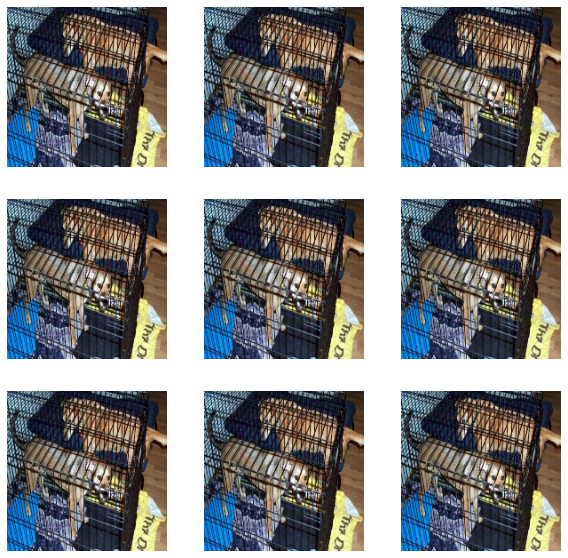

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [24]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

**Training the regularized convnet**

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 8s 99ms/step - loss: 0.6952 - accuracy: 0.4870 - val_loss: 0.6927 - val_accuracy: 0.4990
Epoch 2/50
63/63 [==============================] - 6s 94ms/step - loss: 0.6942 - accuracy: 0.4815 - val_loss: 0.6931 - val_accuracy: 0.5010
Epoch 3/50
63/63 [==============================] - 6s 96ms/step - loss: 0.6917 - accuracy: 0.5080 - val_loss: 0.6931 - val_accuracy: 0.5050
Epoch 4/50
63/63 [==============================] - 6s 96ms/step - loss: 0.6903 - accuracy: 0.5245 - val_loss: 0.6837 - val_accuracy: 0.5600
Epoch 5/50
63/63 [==============================] - 6s 95ms/step - loss: 0.6929 - accuracy: 0.5205 - val_loss: 0.6929 - val_accuracy: 0.5110
Epoch 6/50
63/63 [==============================] - 6s 95ms/step - loss: 0.6937 - accuracy: 0.5190 - val_loss: 0.6966 - val_accuracy: 0.5000
Epoch 7/50
63/63 [==============================] - 6s 93ms/step - loss: 0.6889 - accuracy: 0.5310 - val_loss: 0.6898 - val_accuracy: 0.5350
Epoch 8/50
63

**Evaluating the model on the test set**

In [26]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 36ms/step - loss: 0.4885 - accuracy: 0.7820
Test accuracy: 0.782


Here we can see that test accuracy increased from 70.20% to 78.20%. This increment is due to increase in training sample and able to reduce overfit by using Data augmentation. 

We have increased the training data points from 1000 to 1500
We have considered Epoch 46 to evaluate the model.

Q3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.

Increasing the training sample to 2000, keeping the Validation and test sets the same as before(500 samples)

In [27]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

Defining a new convnet with increased training samples,image augmentation and dropout

In [28]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 8s 100ms/step - loss: 0.6957 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 6s 98ms/step - loss: 0.6932 - accuracy: 0.5045 - val_loss: 0.6870 - val_accuracy: 0.5550
Epoch 3/50
63/63 [==============================] - 6s 95ms/step - loss: 0.6893 - accuracy: 0.5310 - val_loss: 0.6949 - val_accuracy: 0.5060
Epoch 4/50
63/63 [==============================] - 6s 99ms/step - loss: 0.6899 - accuracy: 0.5225 - val_loss: 0.6784 - val_accuracy: 0.5500
Epoch 5/50
63/63 [==============================] - 6s 97ms/step - loss: 0.6813 - accuracy: 0.5620 - val_loss: 0.6802 - val_accuracy: 0.5540
Epoch 6/50
63/63 [==============================] - 6s 95ms/step - loss: 0.6896 - accuracy: 0.5335 - val_loss: 0.6861 - val_accuracy: 0.5450
Epoch 7/50
63/63 [==============================] - 6s 95ms/step - loss: 0.6850 - accuracy: 0.5320 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 8/50
6

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
Test accuracy - 77.50
Train accuracy - 88.20
Validation accuracy - 82.80

As we know, data augmentation stops the model from becoming overfit. Certain augmentation combinations may result in underfitting. Additionally, the model is unable to process enough data to make good predictions, which again reduces accuracy. From this, we may infer the same conclusion.

Data augmentation has allowed us to expand the number of data points, but we have not yet achieved the greatest results.

### Feature extraction with a pretrained model

Q4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.

**Instantiating the VGG16 convolutional base**

In [30]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [31]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [32]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 17ms/step


In [33]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [34]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 10ms/step - loss: 14.1413 - accuracy: 0.9270 - val_loss: 4.1694 - val_accuracy: 0.9740
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 4.2337 - accuracy: 0.9695 - val_loss: 5.8007 - val_accuracy: 0.9650
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1.0247 - accuracy: 0.9860 - val_loss: 7.0271 - val_accuracy: 0.9680
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.2606 - accuracy: 0.9895 - val_loss: 6.0995 - val_accuracy: 0.9730
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 0.6982 - accuracy: 0.9910 - val_loss: 5.5694 - val_accuracy: 0.9680
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 0.7481 - accuracy: 0.9940 - val_loss: 4.2374 - val_accuracy: 0.9780
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 0.8968 - accuracy: 0.9940 - val_loss: 6.9819 - val_accuracy: 0.9720
Epoch 8/20
63/63 [

**Plotting the results**

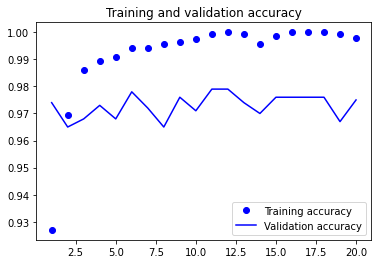

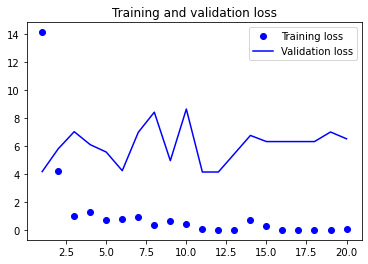

In [35]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [36]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [37]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [38]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [39]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [40]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 15s 215ms/step - loss: 20.4303 - accuracy: 0.8930 - val_loss: 5.8101 - val_accuracy: 0.9580
Epoch 2/50
63/63 [==============================] - 14s 215ms/step - loss: 6.7368 - accuracy: 0.9465 - val_loss: 2.5610 - val_accuracy: 0.9840
Epoch 3/50
63/63 [==============================] - 14s 212ms/step - loss: 6.5848 - accuracy: 0.9565 - val_loss: 5.7077 - val_accuracy: 0.9680
Epoch 4/50
63/63 [==============================] - 13s 208ms/step - loss: 6.1121 - accuracy: 0.9580 - val_loss: 3.6845 - val_accuracy: 0.9800
Epoch 5/50
63/63 [==============================] - 13s 206ms/step - loss: 5.0244 - accuracy: 0.9610 - val_loss: 5.1383 - val_accuracy: 0.9800
Epoch 6/50
63/63 [==============================] - 13s 205ms/step - loss: 3.9590 - accuracy: 0.9685 - val_loss: 4.5437 - val_accuracy: 0.9760
Epoch 7/50
63/63 [==============================] - 13s 207ms/step - loss: 2.7516 - accuracy: 0.9730 - val_loss: 4.1021 - val_accuracy: 0.976

**Evaluating the model on the test set**

In [41]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 115ms/step - loss: 2.4791 - accuracy: 0.9780
Test accuracy: 0.978


### Fine-tuning a pretrained model

In [42]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [43]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [44]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 17s 239ms/step - loss: 0.4488 - accuracy: 0.9915 - val_loss: 2.1248 - val_accuracy: 0.9770
Epoch 2/30
63/63 [==============================] - 15s 238ms/step - loss: 0.2818 - accuracy: 0.9910 - val_loss: 1.8582 - val_accuracy: 0.9780
Epoch 3/30
63/63 [==============================] - 15s 236ms/step - loss: 0.4848 - accuracy: 0.9890 - val_loss: 1.5537 - val_accuracy: 0.9790
Epoch 4/30
63/63 [==============================] - 15s 229ms/step - loss: 0.3986 - accuracy: 0.9910 - val_loss: 1.6889 - val_accuracy: 0.9780
Epoch 5/30
63/63 [==============================] - 15s 229ms/step - loss: 0.3025 - accuracy: 0.9900 - val_loss: 2.9498 - val_accuracy: 0.9720
Epoch 6/30
63/63 [==============================] - 15s 228ms/step - loss: 0.1203 - accuracy: 0.9930 - val_loss: 1.6407 - val_accuracy: 0.9790
Epoch 7/30
63/63 [==============================] - 15s 233ms/step - loss: 0.2110 - accuracy: 0.9950 - val_loss: 1.7543 - val_accuracy: 0.9810

In [45]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 116ms/step - loss: 1.4349 - accuracy: 0.9810
Test accuracy: 0.981


Using a Pre-trained model without Augmentation
We reach a validation accuracy of about 97.80% which is better than what we achieved while training the small model from scratch. However, the plots also indicate that we’re overfitting almost from the start—despite using dropout with a fairly large rate.

Using a Pre-trained model with Augmentation
A model’s accuracy always depends on the set of samples one evaluates it on! Some sample sets may be more difficult than others, and strong results on one set won’t necessarily fully translate to all other sets. because of this reason, Pretrained model With Augmentation, there was just a minor increase in the accuracy from 97.80% to 98.10%.

Conclusion:
As we know, increasing the data points or training samples with better techniques(Data augmentation) we are able to get better results.